In [91]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
%matplotlib nbagg

In [192]:
df = pd.read_hdf('kraken_1042.hdf',key='table')
rand_sample=np.random.permutation(range(len(df)))[:20000]
df=df.ix[rand_sample]
df=df.dropna()

In [193]:
df.columns

Index([u'sessionID', u'propID', u'fieldID', u'fieldRA', u'fieldDec', u'filter',
       u'expDate', u'expMJD', u'night', u'visitTime', u'visitExpTime',
       u'finRank', u'FWHMeff', u'FWHMgeom', u'transparency', u'airmass',
       u'vSkyBright', u'filtSkyBrightness', u'rotSkyPos', u'rotTelPos', u'lst',
       u'altitude', u'azimuth', u'dist2Moon', u'solarElong', u'moonRA',
       u'moonDec', u'moonAlt', u'moonAZ', u'moonPhase', u'sunAlt', u'sunAz',
       u'phaseAngle', u'rScatter', u'mieScatter', u'moonIllum', u'moonBright',
       u'darkBright', u'rawSeeing', u'wind', u'humidity', u'slewDist',
       u'slewTime', u'fiveSigmaDepth', u'ditheredRA', u'ditheredDec'],
      dtype='object')

In [194]:
df.shape

(19997, 46)

### Plot the correlation matrix between variables

<IPython.core.display.Javascript object>


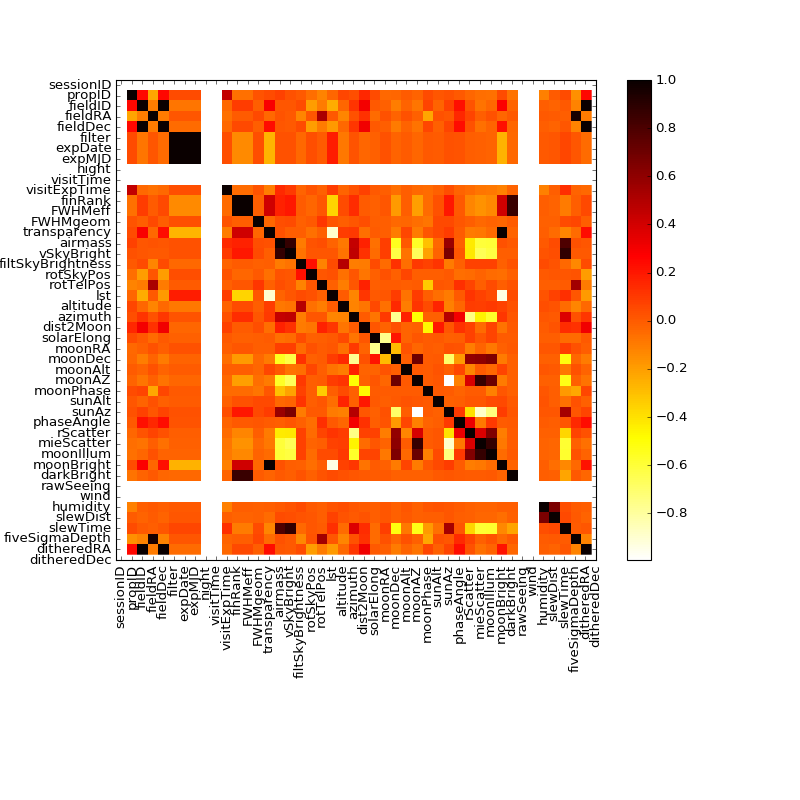

In [337]:
plt.figure(figsize=(10,10))
C=df.corr()

plt.imshow(C,cmap='hot_r',interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(df.columns)),df.columns,rotation=90);
plt.yticks(range(len(df.columns)),df.columns);
plt.subplots_adjust(bottom=0.3)

### Initial machine learning explorations

In [197]:
df_new=df.drop('fiveSigmaDepth',axis=1)
y=df['fiveSigmaDepth']

In [198]:
df_new.shape

(19997, 45)

In [199]:
df_new=pd.get_dummies(df_new) #Hot encode categorical variables. Pandas is awesome.

In [200]:
X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size=0.33, random_state=42)

In [201]:
clf=RandomForestRegressor(n_estimators=20) #These parameters should still be optimised with CV

In [202]:
clf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [339]:
y_fit=clf.predict(X_test)

<IPython.core.display.Javascript object>


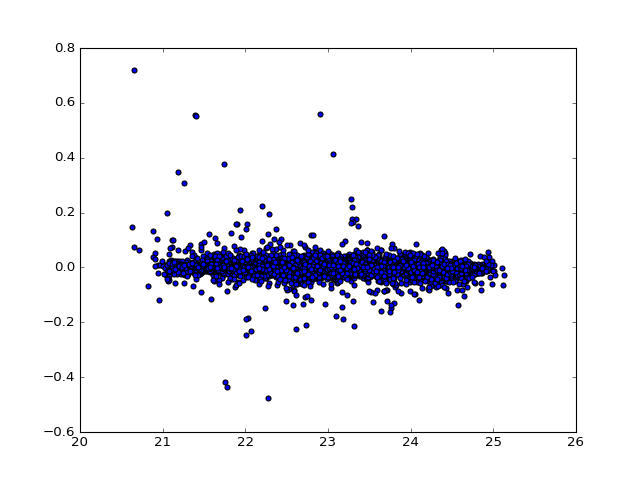

In [209]:
plt.figure()
plt.scatter(y_test,y_fit-y_test)

In [205]:
np.mean(abs(y_fit-y_test))

0.014407945950305529

In [220]:
inds=np.argsort(clf.feature_importances_)[::-1]
print clf.feature_importances_[inds]
print df_new.columns[inds]

[  8.62523487e-01   6.27115731e-02   2.92235642e-02   2.33892127e-02
   1.38607037e-02   2.17482859e-03   1.36238429e-03   1.12339409e-03
   9.31404569e-04   4.77242112e-04   4.76271136e-04   4.12762987e-04
   2.67684684e-04   2.26550553e-04   1.61685089e-04   5.04283679e-05
   3.84693680e-05   3.44265759e-05   3.20408251e-05   3.12541041e-05
   2.86967710e-05   2.83151897e-05   2.52108374e-05   2.47583197e-05
   2.42774159e-05   2.37251863e-05   2.24667814e-05   2.24173131e-05
   2.21057270e-05   2.19536700e-05   2.18379715e-05   2.00992741e-05
   1.98958104e-05   1.98361285e-05   1.98347937e-05   1.80505501e-05
   1.74401937e-05   1.73079235e-05   1.67548761e-05   1.59406984e-05
   1.56453059e-05   1.52887645e-05   1.25524458e-05   1.14883732e-05
   4.73206890e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
Index([u'filtSkyBrightness', u'filter_u', u'FWHMgeom', u'FWHMeff', u'filter_y',
       u'rawSeeing', u'vSkyBright', u'filter_z', u'airma

<IPython.core.display.Javascript object>


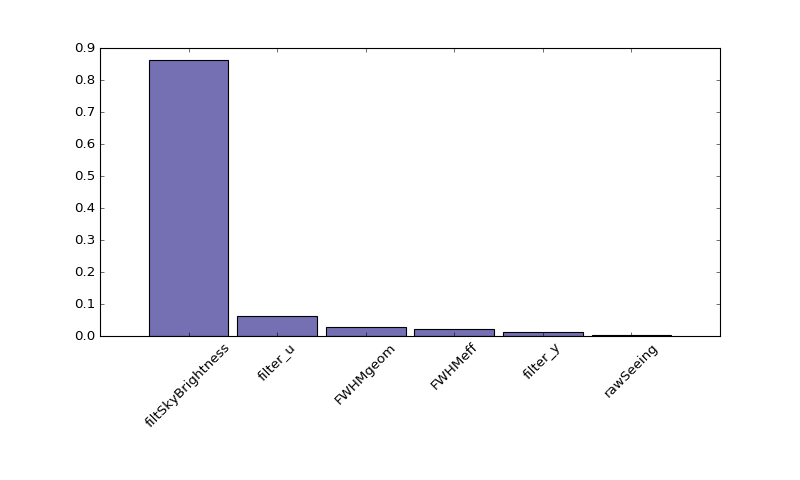

In [227]:
wth=0.9
plt.figure(figsize=(10,6))
plt.bar(range(len(clf.feature_importances_[inds[:nfeats]])),clf.feature_importances_[inds[:nfeats]],
        width=wth,align='center',color='#7570b3',
        edgecolor='k')
blah=plt.xticks(range(len(clf.feature_importances_[inds[:nfeats]])),df_new.columns[inds[:nfeats]],rotation=45)
plt.subplots_adjust(bottom=0.3)

### Now let's try predicting fiveSigmaDepth for each filter band (excluding sky brightness)

In [357]:
def predict_variable(df,filt='r',predicted_variable='fiveSigmaDepth',plot=False,print_output=True):
    
    #Because of the weirdness that the alt=itude of the sun is somehow important (something to do with not having a
    #twilight model), we're leaving this out
    df_new=df[np.rad2deg(df['sunAlt'])<-20]
    
    df_new=df_new[df_new['filter']==filt]
    df_new=df_new.drop('filter',axis=1)
    y=df_new[predicted_variable]
    
    df_new=df_new.drop('fiveSigmaDepth',axis=1)
    df_new=df_new.drop('filtSkyBrightness',axis=1)
    df_new=df_new.drop('propID',axis=1) #This is artificially correlated with spacial information
    df_new=df_new.drop('vSkyBright',axis=1)#Highly correlated with filtskybrightness
    df_new=df_new.drop('FWHMeff',axis=1) #Highly correlated with FWHMgeom
    df_new=df_new.drop('FWHMgeom',axis=1) #Highly correlated with raw seeing
     
    
    X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size=0.33)
    
    clf=RandomForestRegressor(n_estimators=20)
    clf.fit(X_train,y_train)
    y_fit=clf.predict(X_test)
    
    
    inds=np.argsort(clf.feature_importances_)[::-1]
    if print_output:
        print 'Feature importances'
        print clf.feature_importances_[inds]
        print 'Corresponding features'
        print df_new.columns[inds]
        print 'Average error in mag',np.mean(np.abs(y_fit-y_test))
    
    if plot:
        wth=0.9
        nfeats=6
        plt.figure(figsize=(10,6))
        plt.bar(range(len(clf.feature_importances_[inds[:nfeats]])),clf.feature_importances_[inds[:nfeats]],
                width=wth,align='center',color='#7570b3',
                edgecolor='k')
        blah=plt.xticks(range(len(clf.feature_importances_[inds[:nfeats]])),df_new.columns[inds[:nfeats]],rotation=45)
        plt.subplots_adjust(bottom=0.3)
        plt.ylabel('Importance',fontsize=14)

        plt.figure()
        plt.scatter(y_test,y_fit,color='#2727c1')
        plt.xlabel('True value',fontsize=14)
        plt.ylabel('Predicted value',fontsize=14)
        
    
    
    return clf.feature_importances_,y_test,y_fit

u


<IPython.core.display.Javascript object>


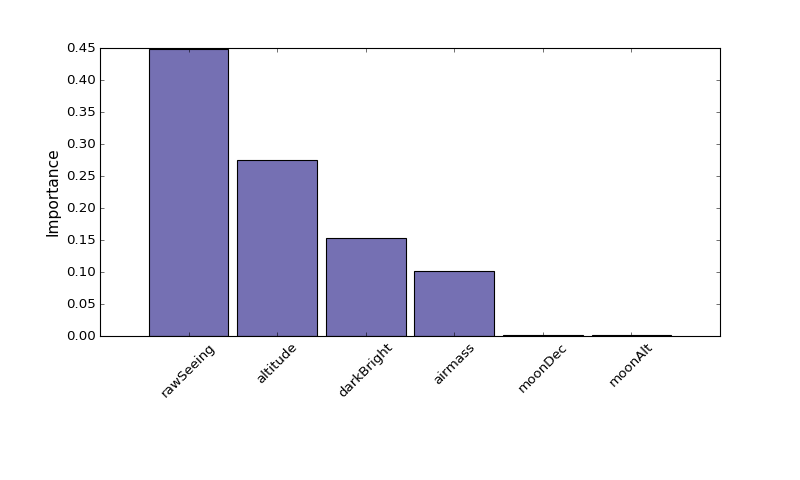

<IPython.core.display.Javascript object>


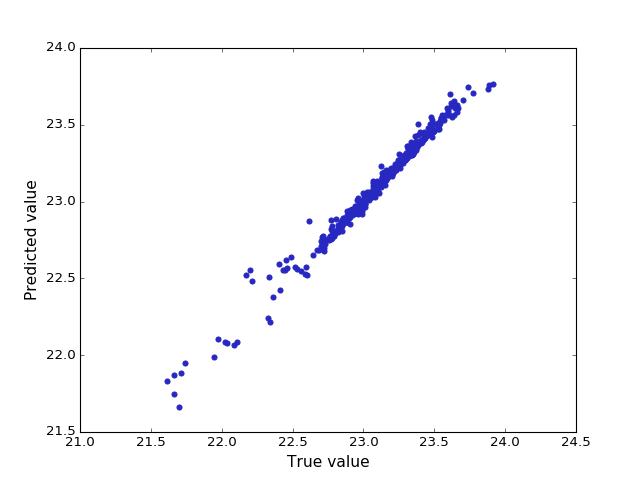

g


<IPython.core.display.Javascript object>


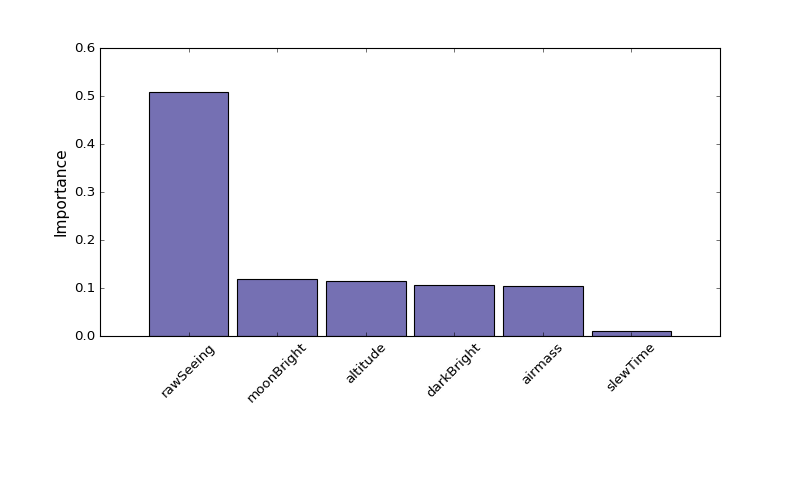

<IPython.core.display.Javascript object>


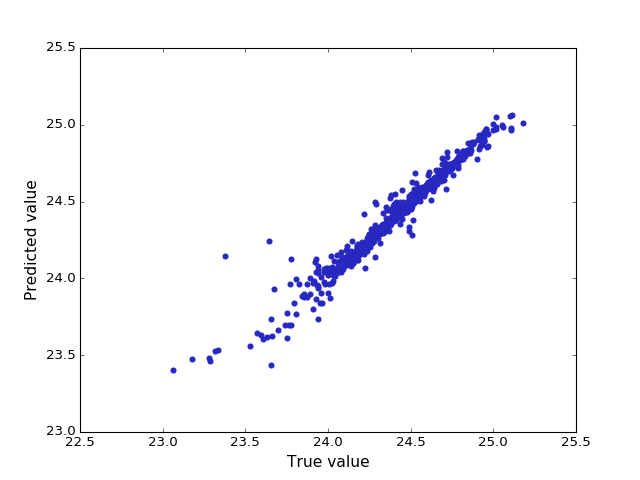

r


<IPython.core.display.Javascript object>


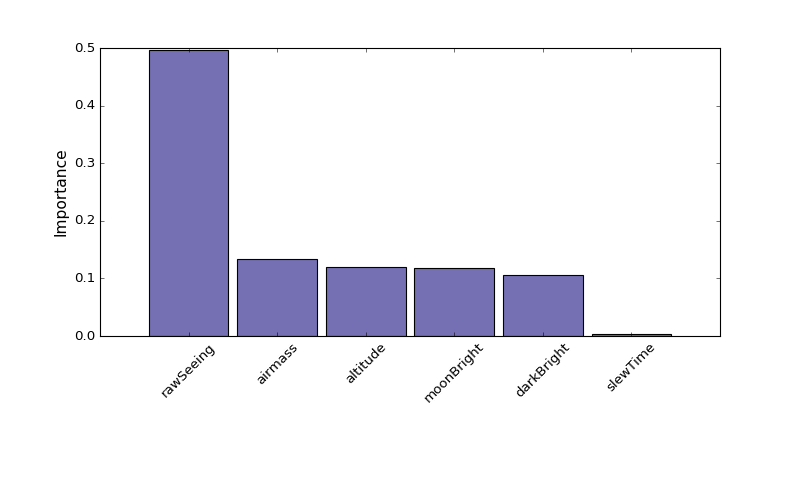

<IPython.core.display.Javascript object>


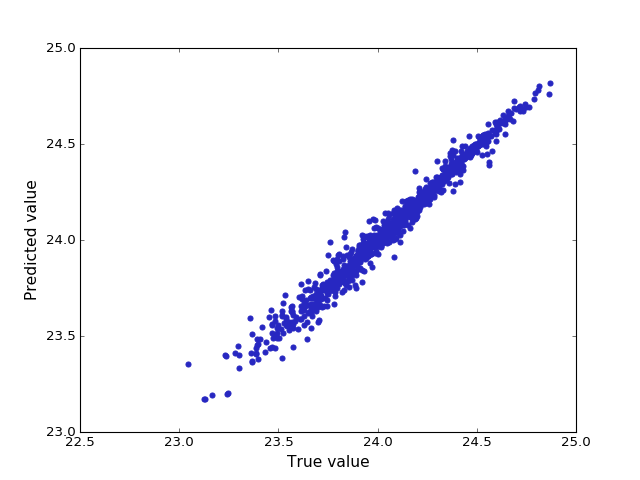

i


<IPython.core.display.Javascript object>


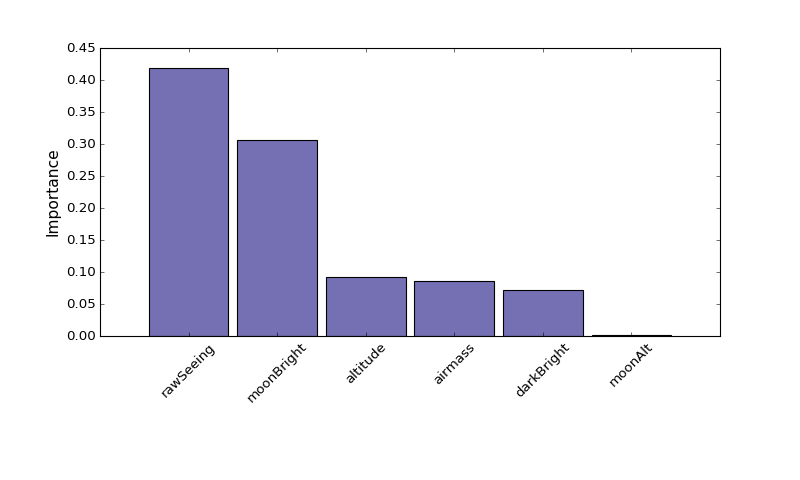

<IPython.core.display.Javascript object>


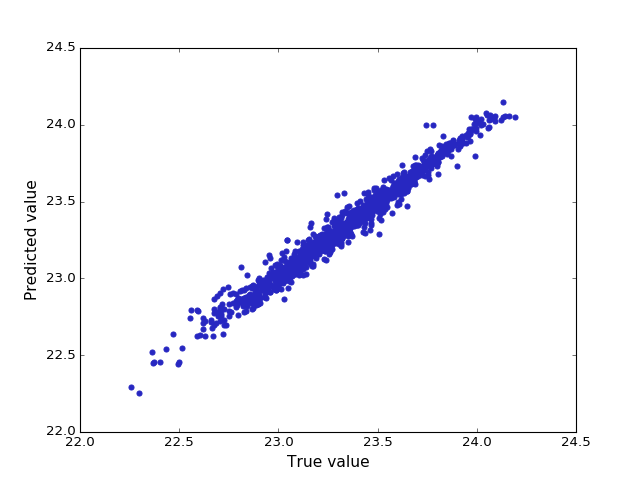

z


<IPython.core.display.Javascript object>


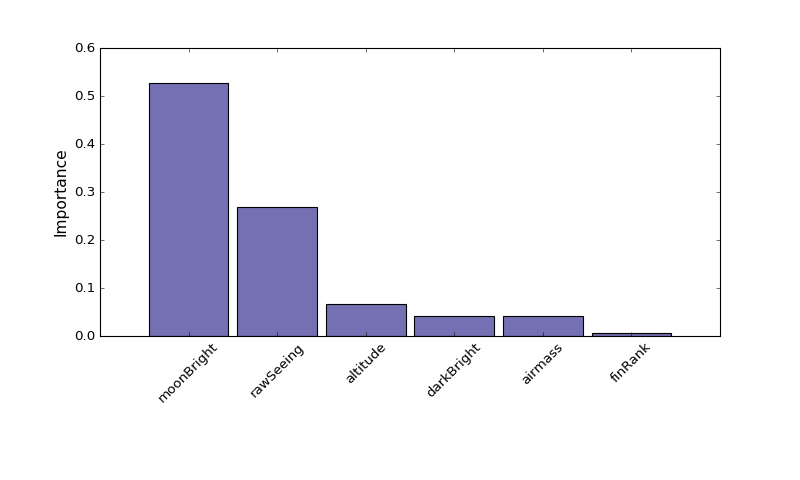

<IPython.core.display.Javascript object>


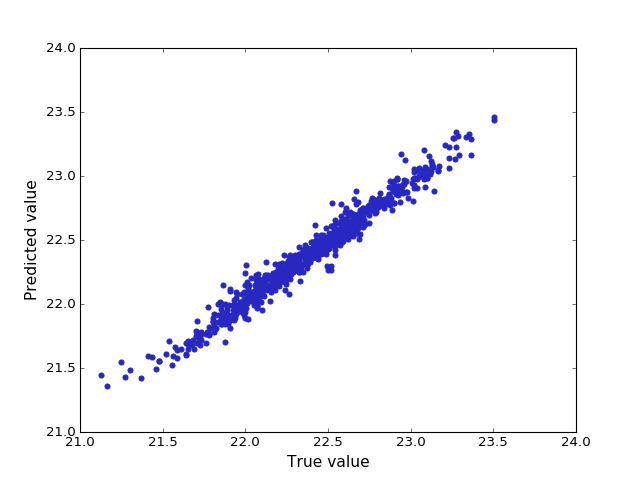

y


<IPython.core.display.Javascript object>


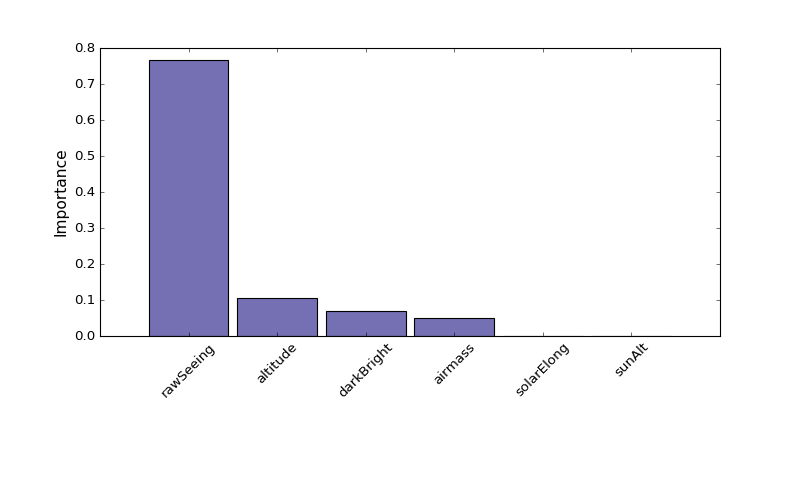

<IPython.core.display.Javascript object>


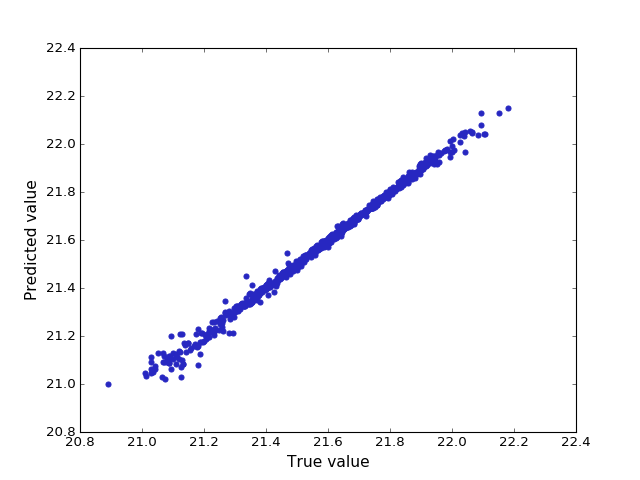

In [358]:
filts=['u','g','r','i','z','y']
for f in filts:
    print f
    feature_importances,y_test,y_fit=predict_variable(df,f,predicted_variable='fiveSigmaDepth',
                                                               plot=True,print_output=False)
    